In [ ]:
!pip install -U tensorflow
!pip install -U sklearn

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud
import seaborn as sns
import itertools
import json
import gensim
from sklearn.metrics import classification_report, accuracy_score


tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
PATH = "/content/gdrive/My Drive/FakeNewsDetection/"

Mounted at /content/gdrive


In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

#DATASET 1

In [ ]:
fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 1
true_data['label'] = 0

In [ ]:
# Clean data
# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
# Combining Title and Text
true_data["text"] = true_data["title"] + " " + true_data["text"]
fake_data["text"] = fake_data["title"] + " " + fake_data["text"]

# Drop Date, title, subject 
true_data = true_data.drop(["subject", "date","title"], axis=1)
fake_data = fake_data.drop(["subject", "date", "title"], axis=1)

In [ ]:
news_data = pd.concat([fake_data, true_data]).reset_index(drop = True)
news_data = shuffle(news_data)
news_data = news_data.reset_index(drop=True)
del fake_data, true_data

## Text articles -> Word2Vec -> LSTM

In [ ]:
y = news_data["label"].values
#Converting train data to gensim format, remove punctuation and stopwords
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in news_data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del news_data

In [ ]:
# Dimension of generated vectors
EMBEDDING_DIM = 10
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

122248

In [ ]:
w2v_model["corona"]
w2v_model.wv.most_similar("trump")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.9826008677482605),
 ('elect', 0.9047054052352905),
 ('2016curious', 0.9037299752235413),
 ('presidency', 0.8834552764892578),
 ('becomes', 0.8706575036048889),
 ('surprise', 0.8704681396484375),
 ('outshone', 0.8675214052200317),
 ('dimished', 0.8659388422966003),
 ('demcorats', 0.8609744310379028),
 ('gla', 0.8598387241363525)]

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news to 1000
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). 
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#Getting embedding vectors from word2vec
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
#Defining Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
del embedding_vectors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=20)

Epoch 1/20
790/790 [==============================] - 35s 44ms/step - loss: 0.1581 - acc: 0.9422 - val_loss: 0.1347 - val_acc: 0.9511
Epoch 2/20
790/790 [==============================] - 35s 44ms/step - loss: 0.1161 - acc: 0.9574 - val_loss: 0.0939 - val_acc: 0.9686
Epoch 3/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0944 - acc: 0.9658 - val_loss: 0.0824 - val_acc: 0.9732
Epoch 4/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0702 - acc: 0.9753 - val_loss: 0.0889 - val_acc: 0.9685
Epoch 5/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0611 - acc: 0.9793 - val_loss: 0.0609 - val_acc: 0.9798
Epoch 6/20
790/790 [==============================] - 34s 44ms/step - loss: 0.0801 - acc: 0.9713 - val_loss: 0.0867 - val_acc: 0.9694
Epoch 7/20
790/790 [==============================] - 35s 44ms/step - loss: 0.0991 - acc: 0.9642 - val_loss: 0.1090 - val_acc: 0.9622
Epoch 8/20
790/790 [==============================] - 35s 44ms

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9879732739420936
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5364
           1       0.98      1.00      0.99      5861

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



([<matplotlib.axis.XTick at 0x7f36606fc7f0>,
 <a list of 20 Text major ticklabel objects>)

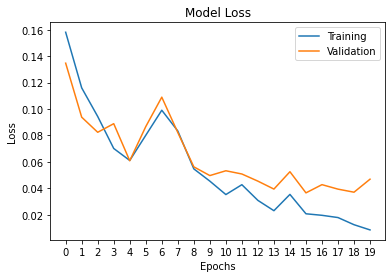

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

Confusion matrix, without normalization


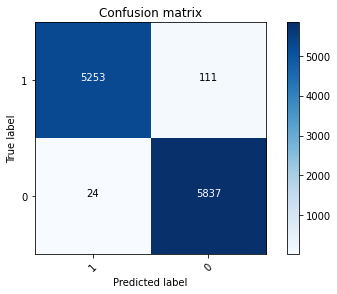

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix(cm, classes=[1, 0])

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.legend(['Training', 'Validation'])
# plt.ylabel('Accuracy (%)')
# plt.xlabel('Epochs')
# plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

KeyError: ignored

## Dataset1 - Dataset 2

In [ ]:
# Dataset 2
X_test = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
# Merge title and text column
X_test["text"] =X_test["title"] + " " + X_test["text"]

# Remove useless columns
X_test.drop(["title"],axis=1,inplace=True)
X_test.drop(["id"],axis=1,inplace=True)
X_test.drop(["author"],axis=1,inplace=True)

In [ ]:
Y = X_test["label"].values
# Convert train data to gensim format, removing punctuation, stopwords
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_test["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(str(par))
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_test

In [ ]:
#Dimension of vectors generated
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Metrics
prediction = model.predict(X)

In [ ]:
prediction2 = np.array([0 if i  == "true" else 1 for i in prediction])
prediction2

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
print("accuracy: {}%".format(round(accuracy_score(Y, prediction2)*100,2)))
print(classification_report(Y, prediction2))

accuracy: 54.62%
              precision    recall  f1-score   support

           0       0.53      0.73      0.62     10387
           1       0.57      0.36      0.45     10413

    accuracy                           0.55     20800
   macro avg       0.55      0.55      0.53     20800
weighted avg       0.55      0.55      0.53     20800



Confusion matrix, without normalization


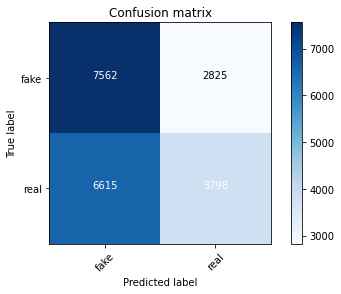

In [ ]:
cm = metrics.confusion_matrix(Y, prediction2)
confusion_matrix(cm, classes=['fake', 'real'])

## Dataset 1 - Dataset 3

In [ ]:
X_test = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))

In [ ]:
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

In [ ]:
X = []
Y = []

In [ ]:
def pre_process(df):
    for i in range(len(df["content"])):
        tmp = []
        sentences = nltk.sent_tokenize(str(df['content'][i]))
        for sent in sentences:
            sent = sent.lower()
            tokens = tokenizer.tokenize(sent)
            del sent
            filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
            del tokens
            tmp.extend(filtered_words)
            del filtered_words
        X.append(tmp)
        Y.append(df['type'][i])
        del sentences, tmp, df['content'][i], df['type'][i]
    del df

pre_process(X_test)

In [ ]:
#Dimension of vectors generated
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Metrics
prediction = model.predict(X)
print("accuracy: {}%".format(round(accuracy_score(Y, prediction)*100,2)))
print(classification_report(Y, prediction))

accuracy: 49.85%
              precision    recall  f1-score   support

        fake       0.49      0.33      0.39     24729
        true       0.50      0.66      0.57     25272

    accuracy                           0.50     50001
   macro avg       0.50      0.50      0.48     50001
weighted avg       0.50      0.50      0.48     50001



Confusion matrix, without normalization


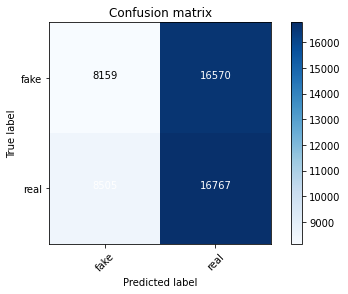

In [ ]:
cm = metrics.confusion_matrix(Y, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

## Text articles -> LSTM

In [ ]:
## train/test split the text data and labels
features = news_data['text']
labels = news_data['label']
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)


In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

In [ ]:
## not removing stop words to maintain word context
max_words = 2000
max_len = 400

token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(X_train.values)
sequences = token.texts_to_sequences(X_train.values)
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)


In [ ]:
embed_dim = 50
lstm_out = 64
batch_size = 32

model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(train_sequences_padded, y_train, batch_size=batch_size, epochs = 20, validation_split=0.25)

In [ ]:
# now compare to test values
test_sequences = token.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
model.evaluate(test_sequences_padded, y_test)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])


# DATASET 2

In [ ]:
# Dataset 2
X_train_2 = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_train_2 = shuffle(X_train_2)
X_train_2 = X_train_2.reset_index(drop=True)

In [ ]:
X_train_2.head()

,id,title,author,text,label
0,16023,We Are The Anunnaki’s Son’s,Arnold Monteverde (noreply@blogger.com),"We are the Anunnaki’s sons, and have been give...",1
1,5461,"John D. Loudermilk, Who Wrote ‘Tobacco Road’ a...",William Grimes,"John D. Loudermilk, a country singer and proli...",0
2,8383,France and Germany Unite to Oppose President T...,Breitbart London,PARIS (AP) — France and Germany formed a un...,0
3,11697,Migrant Crime and Violence Soars in German Sta...,Virginia Hale,Authorities in two German states have expresse...,0
4,10814,EU Takes Centre Stage in ’Chaotic’ French Pres...,Nick Hallett,France’s future in the European Union was the ...,0


In [ ]:
# Combining Title and Text
X_train_2["text"] = X_train_2["title"] + " " + X_train_2["text"]

# Drop id, title, author 
X_train_2 = X_train_2.drop(["id", "author","title"], axis=1)

## Text articles -> Word2Vec -> LSTM

In [ ]:
y = X_train_2["label"].values
#Converting data train to gensim format 
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_train_2["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(str(par))
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_train_2

In [ ]:
#Dimension of generated vectors 
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news to 1000
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#Getting embedding vectors from word2vec 
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
#Defining Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
del embedding_vectors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=20)

Epoch 1/20
342/342 [==============================] - 17s 49ms/step - loss: 0.2993 - acc: 0.8778 - val_loss: 0.2409 - val_acc: 0.9041
Epoch 2/20
342/342 [==============================] - 16s 47ms/step - loss: 0.2161 - acc: 0.9118 - val_loss: 0.2166 - val_acc: 0.9122
Epoch 3/20
342/342 [==============================] - 16s 47ms/step - loss: 0.1764 - acc: 0.9312 - val_loss: 0.1476 - val_acc: 0.9476
Epoch 4/20
342/342 [==============================] - 16s 48ms/step - loss: 0.1194 - acc: 0.9565 - val_loss: 0.1496 - val_acc: 0.9502
Epoch 5/20
342/342 [==============================] - 16s 48ms/step - loss: 0.1091 - acc: 0.9603 - val_loss: 0.0978 - val_acc: 0.9632
Epoch 6/20
342/342 [==============================] - 16s 47ms/step - loss: 0.1676 - acc: 0.9340 - val_loss: 0.1449 - val_acc: 0.9440
Epoch 7/20
342/342 [==============================] - 16s 47ms/step - loss: 0.0972 - acc: 0.9657 - val_loss: 0.0976 - val_acc: 0.9690
Epoch 8/20
342/342 [==============================] - 16s 47ms

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9826923076923076
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2606
           1       0.98      0.98      0.98      2594

    accuracy                           0.98      5200
   macro avg       0.98      0.98      0.98      5200
weighted avg       0.98      0.98      0.98      5200



([<matplotlib.axis.XTick at 0x7f3660a19c18>,
 <a list of 20 Text major ticklabel objects>)

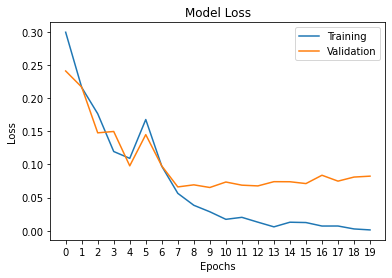

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])


In [ ]:
def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


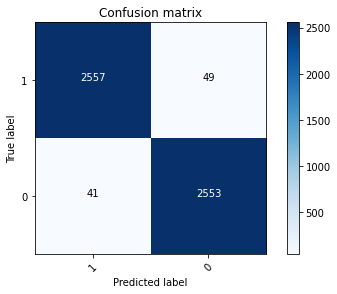

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix(cm, classes=[1, 0])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])


## Dataset 2 - Dataset 1

In [ ]:
#Dataset 1
fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [ ]:
# Clean data
# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
X_test = pd.concat([fake_data, true_data]).reset_index(drop = True)
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
# Merge title and text column
X_test["text"] = X_test["title"] + " " + X_test["text"]

# Remove useless columns
X_test.drop(["title"],axis=1,inplace=True)
X_test.drop(["subject"],axis=1,inplace=True)
X_test.drop(["date"],axis=1,inplace=True)


In [ ]:
Y = X_test["label"].values
# Converting train data to format for gensim library  while removing punctuation, stopwords, lowercasing
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_test["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_test

In [ ]:
#Dimension of vectors generated
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Metrics
prediction = model.predict(X)

In [ ]:
Y2 = np.array([0 if i  == "true" else 1 for i in Y])

In [1]:
print("accuracy: {}%".format(round(accuracy_score(Y2, prediction)*100,2)))
print(classification_report(Y2, prediction))

NameError: ignored

In [2]:
cm = metrics.confusion_matrix(Y2, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

NameError: ignored

## Dataset 2 - Dataset 3

In [ ]:
X_test = pd.read_csv(os.path.join(PATH, "Dataset3/smaller_dataset.csv"))

In [ ]:
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

In [ ]:
X = []
Y = []

In [ ]:
def pre_process(df):
    for i in range(len(df["content"])):
        tmp = []
        sentences = nltk.sent_tokenize(str(df['content'][i]))
        for sent in sentences:
            sent = sent.lower()
            tokens = tokenizer.tokenize(sent)
            del sent
            filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
            del tokens
            tmp.extend(filtered_words)
            del filtered_words
        X.append(tmp)
        Y.append(df['type'][i])
        del sentences, tmp, df['content'][i], df['type'][i]
    del df

pre_process(X_test)

In [ ]:
#Dimension of vectors generated
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
Y2 = np.array([0 if i  == "true" else 1 for i in Y])

In [3]:
# Metrics
prediction = model.predict(X)
print("accuracy: {}%".format(round(accuracy_score(Y2, prediction)*100,2)))
print(classification_report(Y2, prediction))

NameError: ignored

In [4]:
cm = metrics.confusion_matrix(Y2, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

NameError: ignored

## Text articles -> LSTM

In [ ]:
X_train_2 = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_train_2 = shuffle(X_train_2)
X_train_2 = X_train_2.reset_index(drop=True)

## train/test split the text data and labels
features = X_train_2['text']
labels = X_train_2['label']
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)


In [ ]:
## not removing stop words to maintain word context
max_words = 2000
max_len = 400

token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(X_train.values)
sequences = token.texts_to_sequences(X_train.values)
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)


In [ ]:
embed_dim = 50
lstm_out = 64
batch_size = 32

model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(train_sequences_padded, y_train, batch_size=batch_size, epochs = 5, validation_split=0.2)

In [ ]:
# now compare to test values
test_sequences = token.texts_to_sequences(X_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
model.evaluate(test_sequences_padded, y_test)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4])

# DATASET 3

In [ ]:
X = []
Y = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def read_big_dataset(number):
    print(number)
    df = pd.read_csv(os.path.join(PATH, "Dataset3/news_cleaned_" + str(number) + ".csv"))
    df['type'] = df['type'].apply(lambda x: 'true' if x == 'reliable' else 'fake')
    df["content"] = df["title"] + " " + df["content"]
    df.drop(["title"],axis=1,inplace=True)
    return df

df = read_big_dataset(1)
df = pd.concat([df, read_big_dataset(2)])
result = pd.concat([df, read_big_dataset(7)])

# read_big_dataset(3)
# read_big_dataset(4)
# read_big_dataset(7)
# read_big_dataset(9)

In [ ]:
result = shuffle(result)
result = result.reset_index(drop=True)

In [ ]:
len(result)

781461

In [ ]:
def pre_process(df, start, end, number):
    X = []
    Y = []
    for i in range(start, end):
        print(i)
        tmp = []
        sentences = nltk.sent_tokenize(str(df['content'][i]))
        for sent in sentences:
            sent = sent.lower()
            tokens = tokenizer.tokenize(sent)
            del sent
            filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
            del tokens
            tmp.extend(filtered_words)
            del filtered_words
        X.append(tmp)
        Y.append(df['type'][i])
        del sentences, tmp, df['content'][i], df['type'][i]
    np.save(os.path.join(PATH, 'X_' + str(number) + '.npy'), X)
    np.save(os.path.join(PATH, 'Y_' + str(number) + '.npy'), Y)

# pre_process(result, 0, int(len(df["content"])/10), 1)
pre_process(result, int(len(df["content"])/10), 2*int(len(df["content"])/10), 2)
pre_process(result, 2*int(len(df["content"])/10), 3*int(len(df["content"])/10), 3)
pre_process(result, 3*int(len(df["content"])/10), 4*int(len(df["content"])/10), 4)
pre_process(result, 4*int(len(df["content"])/10), 5*int(len(df["content"])/10), 5)
pre_process(result, 5*int(len(df["content"])/10), 6*int(len(df["content"])/10), 6)
pre_process(result, 6*int(len(df["content"])/10), 7*int(len(df["content"])/10), 7)
pre_process(result, 7*int(len(df["content"])/10), 8*int(len(df["content"])/10), 8)
pre_process(result, 8*int(len(df["content"])/10), 9*int(len(df["content"])/10), 9)
pre_process(result, 9*int(len(df["content"])/10), int(len(df["content"])/10), 10)

# save(os.path.join(PATH, 'X_1.npy'), X)
# save(os.path.join(PATH, 'Y_1.npy'), Y)

Streaming output truncated to the last 5000 lines.
32620
32621
32622
32623
32624
32625
32626
32627
32628
32629
32630
32631
32632
32633
32634
32635
32636
32637
32638
32639
32640
32641
32642
32643
32644
32645
32646
32647
32648
32649
32650
32651
32652
32653
32654
32655
32656
32657
32658
32659
32660
32661
32662
32663
32664
32665
32666
32667
32668
32669
32670
32671
32672
32673
32674
32675
32676
32677
32678
32679
32680
32681
32682
32683
32684
32685
32686
32687
32688
32689
32690
32691
32692
32693
32694
32695
32696
32697
32698
32699
32700
32701
32702
32703
32704
32705
32706
32707
32708
32709
32710
32711
32712
32713
32714
32715
32716
32717
32718
32719
32720
32721
32722
32723
32724
32725
32726
32727
32728
32729
32730
32731
32732
32733
32734
32735
32736
32737
32738
32739
32740
32741
32742
32743
32744
32745
32746
32747
32748
32749
32750
32751
32752
32753
32754
32755
32756
32757
32758
32759
32760
32761
32762
32763
32764
32765
32766
32767
32768
32769
32770
32771
32772
32773
32774
32775
32776
32777
3

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


37620
37621
37622
37623
37624
37625
37626
37627
37628
37629
37630
37631
37632
37633
37634
37635
37636
37637
37638
37639
37640
37641
37642
37643
37644
37645
37646
37647
37648
37649
37650
37651
37652
37653
37654
37655
37656
37657
37658
37659
37660
37661
37662
37663
37664
37665
37666
37667
37668
37669
37670
37671
37672
37673
37674
37675
37676
37677
37678
37679
37680
37681
37682
37683
37684
37685
37686
37687
37688
37689
37690
37691
37692
37693
37694
37695
37696
37697
37698
37699
37700
37701
37702
37703
37704
37705
37706
37707
37708
37709
37710
37711
37712
37713
37714
37715
37716
37717
37718
37719
37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764


In [ ]:
np.save(os.path.join(PATH, 'X_1.npy'), X)
np.save(os.path.join(PATH, 'Y_1.npy'), Y)

## Dataset3 - Dataset 1

In [ ]:
def pre_process(df):
    for i in range(len(df["content"])):
        tmp = []
        sentences = nltk.sent_tokenize(str(df['content'][i]))
        for sent in sentences:
            sent = sent.lower()
            tokens = tokenizer.tokenize(sent)
            del sent
            filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
            del tokens
            tmp.extend(filtered_words)
            del filtered_words
        X.append(tmp)
        Y.append(df['type'][i])
        del sentences, tmp, df['content'][i], df['type'][i]
    del df

pre_process(news_data)

In [ ]:
#Dataset 1
fake_data = pd.read_csv(os.path.join(PATH, "Dataset/Fake.csv"))
true_data = pd.read_csv(os.path.join(PATH, "Dataset/True.csv"))
fake_data['label'] = 'fake'
true_data['label'] = 'true'

In [ ]:
# Clean data
# Remove publication part
tmp_text = []
for index,row in enumerate(true_data.text.values):
    record = row.split(" -", maxsplit=1)
    if len(record) > 1 and len(record[0]) < 260:
        tmp_text.append(record[1])
    else:
        tmp_text.append(row)

true_data["text"] = tmp_text
del tmp_text, record

In [ ]:
X_test = pd.concat([fake_data, true_data]).reset_index(drop = True)
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
# Merge title and text column
X_test["text"] = X_test["title"] + " " + X_test["text"]

# Remove useless columns
X_test.drop(["title"],axis=1,inplace=True)
X_test.drop(["subject"],axis=1,inplace=True)
X_test.drop(["date"],axis=1,inplace=True)


In [ ]:
Y = X_test["label"].values
# Converting train data to format for gensim library  while removing punctuation, stopwords, lowercasing
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_test["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_test

In [ ]:
#Dimension of vectors generated
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [5]:
# Metrics
prediction = model.predict(X)
print("accuracy: {}%".format(round(accuracy_score(Y, prediction)*100,2)))
print(classification_report(Y, prediction))

NameError: ignored

In [6]:
cm = metrics.confusion_matrix(Y, prediction)
confusion_matrix(cm, classes=['fake', 'real'])

NameError: ignored

## Dataset 3 - Dataset 2

In [ ]:
# Dataset 2
X_test = pd.read_csv(os.path.join(PATH, "Dataset2/train.csv"))
X_test = shuffle(X_test)
X_test = X_test.reset_index(drop=True)

In [ ]:
# Merge title and text column
X_test["text"] =X_test["title"] + " " + X_test["text"]

# Remove useless columns
X_test.drop(["title"],axis=1,inplace=True)
X_test.drop(["id"],axis=1,inplace=True)
X_test.drop(["author"],axis=1,inplace=True)

In [ ]:
Y = X_test["label"].values
# Convert train data to gensim format, removing punctuation, stopwords
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in X_test["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(str(par))
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del X_test

In [ ]:
#Dimension of vectors generated
EMBEDDING_DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news at 1000, add padding to news with less than 1000 words and truncating long ones
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Metrics
prediction = model.predict(X)

In [ ]:
prediction2 = np.array([0 if i  == "true" else 1 for i in prediction])
prediction2

array([1, 0, 1, ..., 0, 0, 0])

In [7]:
print("accuracy: {}%".format(round(accuracy_score(Y, prediction2)*100,2)))
print(classification_report(Y, prediction2))

NameError: ignored

Confusion matrix, without normalization


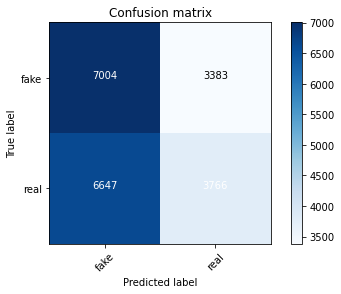

In [ ]:
cm = metrics.confusion_matrix(Y, prediction2)
confusion_matrix(cm, classes=['fake', 'real'])

## Text articles -> Word2Vec -> LSTM

In [ ]:
# Dimension of generated vectors
EMBEDDING_DIM = 10
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

KeyboardInterrupt: ignored

In [ ]:
len(X)

390730

In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [ ]:
# Keep all news to 1000
maxlen = 1000 
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). 
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#Getting embedding vectors from word2vec
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [ ]:
#Defining Neural Network
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
del embedding_vectors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [ ]:
del X, Y

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=20)

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype("int")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix(cm, classes=[1, 0])